# Softmax exercise

*Complete and hand in the completed notebook (including the output) with your assignment submission. You will be submitting the homework as a zip file including all the parts on the Blackboard.*

This exercise is similar to the SVM exercise. In this part, you will:

- Implement a partially-vectorized and fully-vectorized **loss function** for the Softmax classifier.
- Implement the partially-vectorized and fully-vectorized expression for its **analytic gradient**.
- **Compare your implementation** with numerical gradient.
- Use a cross validation to **tune the learning rate and regularization** strength.
- **Optimize** the loss function with stochastic gradient descent (**SGD**).
- **Visualize** the final learned weights.


In [3]:
## Default modules
from __future__ import print_function
import random
import numpy as np
import matplotlib.pyplot as plt

## Custom modules
from ie590.data_utils import load_CIFAR10

## Ipython setup
%matplotlib inline
plt.rcParams['figure.figsize'] = (10.0, 8.0) # set default size of plots
plt.rcParams['image.interpolation'] = 'nearest'
plt.rcParams['image.cmap'] = 'gray'

# for auto-reloading extenrnal modules
# see http://stackoverflow.com/questions/1907993/autoreload-of-modules-in-ipython
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [4]:
## Loading CIFAR 10 data
def get_CIFAR10_data(num_training=49000, num_validation=1000, num_test=1000, num_dev=500):
    """
    Load the CIFAR-10 dataset from disk and perform preprocessing to prepare
    it for the linear classifier. These are the same steps as we used for the
    SVM, but condensed to a single function.  
    """
    # Load the raw CIFAR-10 data
    cifar10_dir = 'ie590/datasets/cifar-10-batches-py'
    
    X_train, y_train, X_test, y_test = load_CIFAR10(cifar10_dir)
    
    # subsample the data
    mask = list(range(num_training, num_training + num_validation))
    X_val = X_train[mask]
    y_val = y_train[mask]
    mask = list(range(num_training))
    X_train = X_train[mask]
    y_train = y_train[mask]
    mask = list(range(num_test))
    X_test = X_test[mask]
    y_test = y_test[mask]
    mask = np.random.choice(num_training, num_dev, replace=False)
    X_dev = X_train[mask]
    y_dev = y_train[mask]
    
    # Preprocessing: reshape the image data into rows
    X_train = np.reshape(X_train, (X_train.shape[0], -1))
    X_val = np.reshape(X_val, (X_val.shape[0], -1))
    X_test = np.reshape(X_test, (X_test.shape[0], -1))
    X_dev = np.reshape(X_dev, (X_dev.shape[0], -1))
    
    # Normalize the data: subtract the mean image
    mean_image = np.mean(X_train, axis = 0)
    X_train -= mean_image
    X_val -= mean_image
    X_test -= mean_image
    X_dev -= mean_image
    
    # add bias dimension and transform into columns
    X_train = np.hstack([X_train, np.ones((X_train.shape[0], 1))])
    X_val = np.hstack([X_val, np.ones((X_val.shape[0], 1))])
    X_test = np.hstack([X_test, np.ones((X_test.shape[0], 1))])
    X_dev = np.hstack([X_dev, np.ones((X_dev.shape[0], 1))])
    
    return X_train, y_train, X_val, y_val, X_test, y_test, X_dev, y_dev


# Cleaning up variables to prevent loading data multiple times (which may cause memory issue)
try:
   del X_train, y_train
   del X_test, y_test
   print('Clear previously loaded data.')
except:
   pass

# Invoke the above function to get our data.
X_train, y_train, X_val, y_val, X_test, y_test, X_dev, y_dev = get_CIFAR10_data()
print('Train data shape: ', X_train.shape)
print('Train labels shape: ', y_train.shape)
print('Validation data shape: ', X_val.shape)
print('Validation labels shape: ', y_val.shape)
print('Test data shape: ', X_test.shape)
print('Test labels shape: ', y_test.shape)
print('dev data shape: ', X_dev.shape)
print('dev labels shape: ', y_dev.shape)

Clear previously loaded data.
Train data shape:  (49000, 3073)
Train labels shape:  (49000,)
Validation data shape:  (1000, 3073)
Validation labels shape:  (1000,)
Test data shape:  (1000, 3073)
Test labels shape:  (1000,)
dev data shape:  (500, 3073)
dev labels shape:  (500,)


## Softmax Classifier

Your code for this section will all be written inside **cs231n/classifiers/softmax.py**. 


In [5]:
'''
First implement the naive softmax loss function with nested loops. 
Open the file ie590/classifiers/softmax.py and implement the 
softmax_loss_naive function. 
'''

from ie590.classifiers.softmax import softmax_loss_naive
import time

# Generate a random softmax weight matrix and use it to compute the loss.
W = np.random.randn(3073, 10) * 0.0001
loss, grad = softmax_loss_naive(W, X_dev, y_dev, 0.0)

# As a rough sanity check, our loss should be something close to -log(0.1).
print('loss: %f' % loss)
print('sanity check: %f' % (-np.log(0.1)))

loss: 2.290418
sanity check: 2.302585


## Inline Question 1:

**Why do we expect our loss to be close to -log(0.1)? Explain briefly.**

$\color{blue}{\textit Your Answer:}$ *Write your answer here*


## Inline Question 2:

**What would be the value of initial loss as number of classes becomes extremely large (inifinity)?**

**Your answer:** When there are inifinite classes, the initial loss will be infinity as $-log(1/\infty) = \infty$


In [6]:
# Complete the implementation of softmax_loss_naive and implement a (naive)
# version of the gradient that uses nested loops.
loss, grad = softmax_loss_naive(W, X_dev, y_dev, 0.0)

# As we did for the SVM, use numeric gradient checking as a debugging tool.
# The numeric gradient should be close to the analytic gradient.
from ie590.gradient_check import grad_check_sparse
f = lambda w: softmax_loss_naive(w, X_dev, y_dev, 0.0)[0]
grad_numerical = grad_check_sparse(f, W, grad, 10)

# similar to SVM case, do another gradient check with regularization
loss, grad = softmax_loss_naive(W, X_dev, y_dev, 5e1)
f = lambda w: softmax_loss_naive(w, X_dev, y_dev, 5e1)[0]
grad_numerical = grad_check_sparse(f, W, grad, 10)

numerical: 0.333335 analytic: 0.333335, relative error: 6.343417e-09
numerical: 3.059595 analytic: 3.059595, relative error: 1.191461e-08
numerical: -0.477317 analytic: -0.477317, relative error: 1.031745e-07
numerical: 1.601209 analytic: 1.601209, relative error: 3.140828e-08
numerical: 0.038892 analytic: 0.038892, relative error: 1.028941e-06
numerical: 2.863159 analytic: 2.863159, relative error: 2.846286e-08
numerical: -0.487861 analytic: -0.487861, relative error: 1.317193e-08
numerical: 0.560405 analytic: 0.560405, relative error: 1.319885e-07
numerical: -2.735207 analytic: -2.735207, relative error: 4.395819e-08
numerical: -1.378978 analytic: -1.378978, relative error: 3.582129e-08
numerical: 1.641373 analytic: 1.641373, relative error: 1.006805e-08
numerical: 4.521304 analytic: 4.521304, relative error: 9.799319e-09
numerical: 1.807061 analytic: 1.807061, relative error: 3.654016e-08
numerical: 0.285120 analytic: 0.285120, relative error: 5.663725e-08
numerical: -0.341211 analy

In [10]:
# Now that we have a naive implementation of the softmax loss function and its gradient,
# implement a partially vectorized version in softmax_loss_partially_vectorized.
# The two versions should compute the same results, but the partially vectorized version should be
# relatively faster.
tic = time.time()
loss_naive, grad_naive = softmax_loss_naive(W, X_dev, y_dev, 0.000005)
toc = time.time()
print('naive loss: %e computed in %fs' % (loss_naive, toc - tic))

from ie590.classifiers.softmax import softmax_loss_partially_vectorized
tic = time.time()
loss_partially_vectorized, grad_partially_vectorized = softmax_loss_partially_vectorized(W, X_dev, y_dev, 0.000005)
toc = time.time()
print('partially vectorized loss: %e computed in %fs' % (loss_partially_vectorized, toc - tic))

# As we did for the SVM, we use the Frobenius norm to compare the two versions
# of the gradient.
grad_difference = np.linalg.norm(grad_naive - grad_partially_vectorized, ord='fro')
print('Loss difference: %f' % np.abs(loss_naive - loss_partially_vectorized))
print('Gradient difference: %f' % grad_difference)

naive loss: 2.290418e+00 computed in 0.057301s
partially vectorized loss: 2.290418e+00 computed in 0.092045s
Loss difference: 0.000000
Gradient difference: 0.000000


In [14]:
# Now you will implement a fully vectorized version in softmax_loss_vectorized.
# The two versions should compute the same results, but the fully vectorized version should be
# much faster.
tic = time.time()
loss_naive, grad_naive = softmax_loss_naive(W, X_dev, y_dev, 0.000005)
toc = time.time()
print('naive loss: %e computed in %fs' % (loss_naive, toc - tic))

from ie590.classifiers.softmax import softmax_loss_vectorized
tic = time.time()
loss_vectorized, grad_vectorized = softmax_loss_vectorized(W, X_dev, y_dev, 0.000005)
toc = time.time()
print('vectorized loss: %e computed in %fs' % (loss_vectorized, toc - tic))

# As we did for the SVM, we use the Frobenius norm to compare the two versions
# of the gradient.
grad_difference = np.linalg.norm(grad_naive - grad_vectorized, ord='fro')
print('Loss difference: %f' % np.abs(loss_naive - loss_vectorized))
print('Gradient difference: %f' % grad_difference)

naive loss: 2.290418e+00 computed in 0.059296s
vectorized loss: 2.290418e+00 computed in 0.003740s
Loss difference: 0.000000
Gradient difference: 0.000000


In [17]:
# Use the validation set to tune hyperparameters (regularization strength and
# learning rate). You should experiment with different ranges for the learning
# rates and regularization strengths; if you are careful you should be able to
# get a classification accuracy of over 0.34 on the validation set.
from ie590.classifiers import Softmax
results = {}
best_val = -1
best_softmax = Softmax() ## Overwrite this variable with best trained softmax classifier. 
# Feel free to experiment with some other learning rates
learning_rates = [1e-7, 5e-7]
# Feel free to experiment with other values of regularization strength
regularization_strengths = [2.5e4, 5e4] 

################################################################################
# TODO:                                                                        #
# Use the validation set to set the learning rate and regularization strength. #
# This should be identical to the validation that you did for the SVM; save    #
# the best trained softmax classifer in best_softmax.                          #
################################################################################
#                          START OF YOUR CODE                                  #
################################################################################
pass ## Write your code here
################################################################################
#                              END OF YOUR CODE                                #
################################################################################
    
# Print out results.
for lr, reg in sorted(results):
    train_accuracy, val_accuracy = results[(lr, reg)]
    print('lr %e reg %e train accuracy: %f val accuracy: %f' % (
                lr, reg, train_accuracy, val_accuracy))
    
print('best validation accuracy achieved during cross-validation: %f' % best_val)

lr 1.000000e-07 reg 2.500000e+04 train accuracy: 0.330612 val accuracy: 0.336000
lr 1.000000e-07 reg 5.000000e+04 train accuracy: 0.313204 val accuracy: 0.333000
lr 5.000000e-07 reg 2.500000e+04 train accuracy: 0.332102 val accuracy: 0.341000
lr 5.000000e-07 reg 5.000000e+04 train accuracy: 0.310735 val accuracy: 0.325000
best validation accuracy achieved during cross-validation: 0.341000


In [18]:
# evaluate on test set
# Evaluate the best softmax on test set
y_test_pred = best_softmax.predict(X_test)
test_accuracy = np.mean(y_test == y_test_pred)
print('softmax on raw pixels final test set accuracy: %f' % (test_accuracy, ))

softmax on raw pixels final test set accuracy: 0.336000


## Inline Question 3 (True or False):

**It's possible to add a new datapoint to a training set that would leave the SVM loss unchanged, but this is not the case with the Softmax classifier loss.**

*Your answer*: 

*Your explanation*: *Write your answer here*

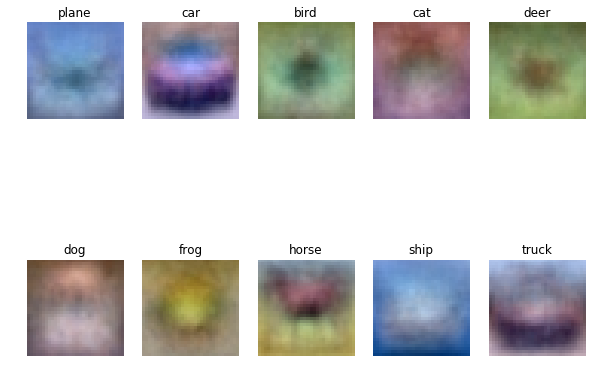

In [19]:
# Visualize the learned weights for each class
w = best_softmax.W[:-1,:] # strip out the bias
w = w.reshape(32, 32, 3, 10)

w_min, w_max = np.min(w), np.max(w)

classes = ['plane', 'car', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck']
for i in range(10):
    plt.subplot(2, 5, i + 1)
    
    # Rescale the weights to be between 0 and 255
    wimg = 255.0 * (w[:, :, :, i].squeeze() - w_min) / (w_max - w_min)
    plt.imshow(wimg.astype('uint8'))
    plt.axis('off')
    plt.title(classes[i])